In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet
/kaggle/input/amex-data-integer-dtypes-parquet-format/test.parquet
/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


# About the Dataset
The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

D_* = Delinquency variables<br>
S_* = Spend variables<br>
P_* = Payment variables<br>
B_* = Balance variables<br>
R_* = Risk variables<br>

with the following features being categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

My task is to predict, for each customer_ID, the probability of a future payment default (target = 1)

**Note that the negative class has been subsampled for this dataset at 5%, and thus receives a 20x weighting in the scoring metric.**

# 1. Importing the libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
from lightgbm import LGBMClassifier
import os
import warnings
import numpy as np
import pandas as pd
import gc 
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)


In [4]:
train_df = pd.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet').groupby('customer_ID').tail(2).set_index('customer_ID', drop=True).sort_index()

In [5]:
train_target=pd.read_csv("/kaggle/input/amex-default-prediction/train_labels.csv")

In [6]:
train_target.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [7]:
train_df=pd.merge(train_df, train_target, on='customer_ID')

In [8]:
train_df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-02-21,0.937349,0,0.019837,1.008307,0.000607,0.102985,0.0,0.007454,NaN,NaN,0,6,0.740062,0.132626,0,0.425848,0.538275,0.237232,-1,0.150155,0.060502,0.0,0.149338,2,0.001064,0,0.207560,0.647352,0.325464,NaN,0.050146,0.007260,0,1.0,0,0.077352,0.111060,2380,0.196520,0.166448,0.092181,0,0.005720,0.013617,0.029953,8,0.141639,0.228128,0.042265,19,0.453934,0,0,0,0,NaN,1.0,0,-1,0,6,0.187413,0.004807,872,0.003347,0.007434,0,0,0.312937,0,5,0.044315,NaN,0.0,0,0,NaN,0.008714,0.0,0.417256,0.009573,0.000013,0,0,0,-1,0.005027,1,0,0,0.002737,0,1,0.007090,1.0,0.098844,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.000869,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0.933347,0.136322,0.950119,0.979136,0.003096,0.922532,1,1.015417,1.067105,-1,2,0.009383,0.018704,-1,1.003859,2,-1,0,NaN,-1,NaN,1.0,0.100918,0.979416,0,1,0.256733,0,5,0.253851,0.247433,0,0.719052,3,0,16,0,2,1,0.999822,1,0,NaN,0.0,0.0,NaN,0.000122,0,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.006346,0,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,NaN,NaN,0,5,0.740102,0.231717,0,0.420521,0.539715,0.192376,-1,0.149564,0.058425,0.0,0.153461,2,0.009535,0,0.203524,0.629392,0.326101,NaN,0.034643,0.010260,0,1.0,0,0.105671,0.112294,1544,0.187285,0.166636,0.100107,0,0.007174,0.007397,0.010239,8,0.258461,0.227637,0.014553,15,0.446568,0,0,0,0,NaN,1.0,0,-1,0,6,0.184036,0.003945,702,0.005375,0.005469,0,0,0.377991,0,6,0.040367,NaN,0.0,0,0,NaN,0.002230,0.0,0.421334,0.006475,0.001068,0,0,0,-1,0.000026,1,0,0,0.007236,0,1,0.006550,1.0,0.084745,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.003511,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0.917811,0.131801,0.936067,0.971994,0.001281,0.943340,1,1.014510,1.073985,-1,2,0.007441,0.008676,-1,1.006130,2,-1,0,NaN,-1,NaN,1.0,0.100454,0.928955,0,1,0.255787,0,5,0.260255,0.256656,0,0.719791,3,0,16,0,2,1,0.999737,1,0,NaN,0.0,0.0,NaN,0.006210,0,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.002970,0,0
2,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-02-06,0.878856,18,0.034558,1.005419,0.007248,0.159486,0.0,0.008733,NaN,0.062028,0,1,0.263736,0.010155,0,0.470223,0.398607,0.010117,-1,0.211673,0.033179,0.0,NaN,1,0.011734,1,0.239160,0.517843,0.301616,NaN,0.006361,0.015018,0,1.0,0,0.136180,0.022597,996,0.047516,0.695723,0.008499,0,0.008624,NaN,0.023292,16,0.524772,0.103022,0.003985,16,0.238523,3,0,0,0,NaN,1.0,0,-1,0,6,0.188421,0.002118,290,0.008382,0.005944,0,0,0.010515,0,7,0.014946,NaN,0.0,0,0,NaN,0.009167,0.0,0.224252,0.033150,0.007601,0,0,0,-1,0.000067,0,0,0,0.000015,0,-1,0.003619,1.0,0.014986,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.009282,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.994174,0.140244,1.011297,0.975712,0.002006,0.001432,0,0.000000,NaN,-1,0,0.004645,0.030284,-1,1.009403,2,-1,0,NaN,-1,NaN,1.0,0.019818,0.003480,0,1,0.448894,0,0,0.438787,0.444072,1,0.539496,2,0,4,0,2,0,1.006768,0,0,NaN,0.0,0.0,NaN,0.009592,0,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.002528,0,0
3,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-25,0.880519,6,0.034684,1.

In [9]:
train_df.shape

(912706, 191)

In [10]:
train_df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-02-21,0.937349,0,0.019837,1.008307,0.000607,0.102985,0.0,0.007454,NaN,NaN,0,6,0.740062,0.132626,0,0.425848,0.538275,0.237232,-1,0.150155,0.060502,0.0,0.149338,2,0.001064,0,0.207560,0.647352,0.325464,NaN,0.050146,0.007260,0,1.0,0,0.077352,0.111060,2380,0.196520,0.166448,0.092181,0,0.005720,0.013617,0.029953,8,0.141639,0.228128,0.042265,19,0.453934,0,0,0,0,NaN,1.0,0,-1,0,6,0.187413,0.004807,872,0.003347,0.007434,0,0,0.312937,0,5,0.044315,NaN,0.0,0,0,NaN,0.008714,0.0,0.417256,0.009573,0.000013,0,0,0,-1,0.005027,1,0,0,0.002737,0,1,0.007090,1.0,0.098844,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.000869,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0.933347,0.136322,0.950119,0.979136,0.003096,0.922532,1,1.015417,1.067105,-1,2,0.009383,0.018704,-1,1.003859,2,-1,0,NaN,-1,NaN,1.0,0.100918,0.979416,0,1,0.256733,0,5,0.253851,0.247433,0,0.719052,3,0,16,0,2,1,0.999822,1,0,NaN,0.0,0.0,NaN,0.000122,0,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.006346,0,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,NaN,NaN,0,5,0.740102,0.231717,0,0.420521,0.539715,0.192376,-1,0.149564,0.058425,0.0,0.153461,2,0.009535,0,0.203524,0.629392,0.326101,NaN,0.034643,0.010260,0,1.0,0,0.105671,0.112294,1544,0.187285,0.166636,0.100107,0,0.007174,0.007397,0.010239,8,0.258461,0.227637,0.014553,15,0.446568,0,0,0,0,NaN,1.0,0,-1,0,6,0.184036,0.003945,702,0.005375,0.005469,0,0,0.377991,0,6,0.040367,NaN,0.0,0,0,NaN,0.002230,0.0,0.421334,0.006475,0.001068,0,0,0,-1,0.000026,1,0,0,0.007236,0,1,0.006550,1.0,0.084745,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.003511,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0.917811,0.131801,0.936067,0.971994,0.001281,0.943340,1,1.014510,1.073985,-1,2,0.007441,0.008676,-1,1.006130,2,-1,0,NaN,-1,NaN,1.0,0.100454,0.928955,0,1,0.255787,0,5,0.260255,0.256656,0,0.719791,3,0,16,0,2,1,0.999737,1,0,NaN,0.0,0.0,NaN,0.006210,0,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.002970,0,0
2,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-02-06,0.878856,18,0.034558,1.005419,0.007248,0.159486,0.0,0.008733,NaN,0.062028,0,1,0.263736,0.010155,0,0.470223,0.398607,0.010117,-1,0.211673,0.033179,0.0,NaN,1,0.011734,1,0.239160,0.517843,0.301616,NaN,0.006361,0.015018,0,1.0,0,0.136180,0.022597,996,0.047516,0.695723,0.008499,0,0.008624,NaN,0.023292,16,0.524772,0.103022,0.003985,16,0.238523,3,0,0,0,NaN,1.0,0,-1,0,6,0.188421,0.002118,290,0.008382,0.005944,0,0,0.010515,0,7,0.014946,NaN,0.0,0,0,NaN,0.009167,0.0,0.224252,0.033150,0.007601,0,0,0,-1,0.000067,0,0,0,0.000015,0,-1,0.003619,1.0,0.014986,0,0,0.0,0,0,0,NaN,0,0,0,-1,0,0,NaN,1,0.009282,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.994174,0.140244,1.011297,0.975712,0.002006,0.001432,0,0.000000,NaN,-1,0,0.004645,0.030284,-1,1.009403,2,-1,0,NaN,-1,NaN,1.0,0.019818,0.003480,0,1,0.448894,0,0,0.438787,0.444072,1,0.539496,2,0,4,0,2,0,1.006768,0,0,NaN,0.0,0.0,NaN,0.009592,0,NaN,-1,-1,-1,-1,0,0,0.0,NaN,0,0.002528,0,0
3,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-25,0.880519,6,0.034684,1.

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 912706 entries, 0 to 912705
Columns: 191 entries, customer_ID to target
dtypes: float32(93), int16(9), int64(1), int8(86), object(2)
memory usage: 442.2+ MB


In [12]:
train_df.describe()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
count,906552.000000,912706.000000,912706.000000,9.125830e+05,9.127060e+05,745687.000000,912583.000000,9.125830e+05,120435.000000,6.449100e+05,912706.000000,912706.000000,912583.000000,9.127060e+05,912706.000000,723096.000000,912706.000000,798767.000000,912706.000000,912574.000000,912706.000000,906047.000000,387964.000000,912706.000000,9.127060e+05,912706.000000,910077.000000,868483.000000,912706.000000,2.606000e+05,9.127060e+05,9.127060e+05,912706.000000,912583.000000,912706.000000,745687.000000,9.127060e+05,912706.000000,851905.000000,420550.000000,9.084840e+05,912706.000000,9.127060e+05,4.960580e+05,912706.000000,912706.000000,9.127060e+05,815652.000000,911484.000000,912706.000000,793609.000000,912706.000000,912706.000000,912706.000000,912706.000000,4.239980e+05,9.127060e+05,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,9.127060e+05,912706.000000,9.127060e+05,8.860510e+05,912706.000000,912706.000000,9.127060e+05,912706.000000,912706.000000,9.127060e+05,8492.000000,912706.000000,912706.000000,912706.000000,9.828700e+04,9.127060e+05,912706.000000,4.884900e+05,911484.000000,9.125830e+05,912706.000000,912706.000000,912706.000000,912706.000000,9.127060e+05,912706.000000,912706.000000,912706.000000,9.125830e+05,912706.000000,912706.000000,9.127060e+05,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,5.419400e+04,912706.00000,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,1493.000000,912706.000000,9.127060e+05,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,909320.000000,912634.000000,909389.000000,910037.000000,9.127020e+05,9.126170e+05,912706.000000,905398.000000,423191.000000,912706.000000,912706.000000,9.127060e+05,912702.000000,912706.000000,860466.000000,912706.000000,912706.000000,912706.000000,7265.000000,912706.000000,8054.000000,9.125790e+05,9.127020e+05,6.837720e+05,912706.000000,912706.000000,886942.000000,912706.000000,912706.000000,8.869420e+05,8.869420e+05,912706.000000,886942.000000,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,905398.000000,912706.000000,912706.000000,12185.000000,905398.000000,905398.000000,101906.000000,9.126170e+05,912706.000000,33831.000000,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,912706.000000,905398.000000,159262.000000,912706.000000,9.126170e+05,912706.000000,912706.000000
mean,0.636799,6.456304,0.138035,5.923208e-01,1.029318e-01,0.229894,0.085989,1.538056e-01,0.179276,1.627040e-01,0.959966,14.147933,0.241745,8.062714e-02,0.070507,0.480609,0.398775,0.407567,0.593127,0.149548,0.200320,0.484275,0.176479,0.415836,2.052503e-01,1.140848,0.179623,0.583013,0.228109,1.071232e-01,8.607299e-02,1.246737e-01,0.236548,0.964874,0.046213,0.223642,9.280799e-02,979.625480,0.329373,0.208687,1.017017e-01,0.121695,2.28

In [13]:
cat=['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

# 2. Data Cleaning

In [14]:
# Missing values
tmp = train_df.isna().sum().mul(100).div(len(train_df)).sort_values(ascending=False)
tmp[:15]

D_88     99.836420
D_110    99.204015
B_39     99.117569
D_73     99.069580
B_42     98.664959
D_134    96.293330
B_29     94.062272
D_76     89.231253
D_132    88.834740
D_42     86.804623
D_142    82.550569
D_53     71.447542
D_50     57.492993
D_56     53.922731
D_105    53.633372
dtype: float64

In [15]:
# dropping columns with missing values >70%
missingDF = pd.DataFrame(tmp).reset_index()
drop_cols = missingDF[missingDF[0]>70]["index"].values
print(drop_cols)

['D_88' 'D_110' 'B_39' 'D_73' 'B_42' 'D_134' 'B_29' 'D_76' 'D_132' 'D_42'
 'D_142' 'D_53']


#### Dropping Null values >70%

In [16]:
train_df.drop(columns = drop_cols,axis=1, inplace=True)

In [17]:
train_df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,P_4,D_74,D_75,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_30,S_18,D_86,D_87,R_17,R_18,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_111,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,D_130,D_131,D_133,R_28,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-02-21,0.937349,0,0.019837,1.008307,0.000607,0.102985,0.0,0.007454,NaN,0,6,0.740062,0.132626,0,0.425848,0.538275,0.237232,-1,0.150155,0.060502,0.0,0.149338,2,0.001064,0,0.207560,0.647352,0.325464,0.050146,0.007260,0,1.0,0,0.077352,0.111060,2380,0.196520,0.166448,0.092181,0,0.005720,0.013617,0.029953,8,0.141639,0.228128,0.042265,19,0.453934,0,0,0,0,NaN,1.0,0,-1,0,6,0.187413,0.004807,872,0.003347,0.007434,0,0,0.312937,0,5,0.044315,0.0,0,0,0.008714,0.0,0.417256,0.009573,0.000013,0,0,0,-1,0.005027,1,0,0,0.002737,0,1,0.007090,1.0,0.098844,0,0,0.0,0,0,0,0,0,0,-1,0,0,1,0.000869,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0.933347,0.136322,0.950119,0.979136,0.003096,0.922532,1,1.015417,1.067105,-1,2,0.009383,0.018704,-1,1.003859,2,-1,0,-1,1.0,0.100918,0.979416,0,1,0.256733,0,5,0.253851,0.247433,0,0.719052,3,0,16,0,2,1,0.999822,1,0,0.0,0.0,0.000122,0,-1,-1,-1,-1,0,0,0.0,0,0.006346,0,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,NaN,0,5,0.740102,0.231717,0,0.420521,0.539715,0.192376,-1,0.149564,0.058425,0.0,0.153461,2,0.009535,0,0.203524,0.629392,0.326101,0.034643,0.010260,0,1.0,0,0.105671,0.112294,1544,0.187285,0.166636,0.100107,0,0.007174,0.007397,0.010239,8,0.258461,0.227637,0.014553,15,0.446568,0,0,0,0,NaN,1.0,0,-1,0,6,0.184036,0.003945,702,0.005375,0.005469,0,0,0.377991,0,6,0.040367,0.0,0,0,0.002230,0.0,0.421334,0.006475,0.001068,0,0,0,-1,0.000026,1,0,0,0.007236,0,1,0.006550,1.0,0.084745,0,0,0.0,0,0,0,0,0,0,-1,0,0,1,0.003511,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0.917811,0.131801,0.936067,0.971994,0.001281,0.943340,1,1.014510,1.073985,-1,2,0.007441,0.008676,-1,1.006130,2,-1,0,-1,1.0,0.100454,0.928955,0,1,0.255787,0,5,0.260255,0.256656,0,0.719791,3,0,16,0,2,1,0.999737,1,0,0.0,0.0,0.006210,0,-1,-1,-1,-1,0,0,0.0,0,0.002970,0,0
2,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-02-06,0.878856,18,0.034558,1.005419,0.007248,0.159486,0.0,0.008733,0.062028,0,1,0.263736,0.010155,0,0.470223,0.398607,0.010117,-1,0.211673,0.033179,0.0,NaN,1,0.011734,1,0.239160,0.517843,0.301616,0.006361,0.015018,0,1.0,0,0.136180,0.022597,996,0.047516,0.695723,0.008499,0,0.008624,NaN,0.023292,16,0.524772,0.103022,0.003985,16,0.238523,3,0,0,0,NaN,1.0,0,-1,0,6,0.188421,0.002118,290,0.008382,0.005944,0,0,0.010515,0,7,0.014946,0.0,0,0,0.009167,0.0,0.224252,0.033150,0.007601,0,0,0,-1,0.000067,0,0,0,0.000015,0,-1,0.003619,1.0,0.014986,0,0,0.0,0,0,0,0,0,0,-1,0,0,1,0.009282,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.994174,0.140244,1.011297,0.975712,0.002006,0.001432,0,0.000000,NaN,-1,0,0.004645,0.030284,-1,1.009403,2,-1,0,-1,1.0,0.019818,0.003480,0,1,0.448894,0,0,0.438787,0.444072,1,0.539496,2,0,4,0,2,0,1.006768,0,0,0.0,0.0,0.009592,0,-1,-1,-1,-1,0,0,0.0,0,0.002528,0,0
3,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-25,0.880519,6,0.034684,1.004028,0.006911,0.165509,0.0,0.005068,0.060646,0,1,0.266275,0.027000,0,0.438828,0.402195,0.014696,-1,0.167634,0.028411,0.0,NaN,1,0.012926,1,0.242366,0.570898,0.297130,0.043929,0.014570,0,1.0,0,0.208516,0.0190

In [18]:
train_df.shape

(912706, 179)

In [19]:
# For categorical columns
cols = train_df.columns
num_cols = train_df._get_numeric_data().columns

In [20]:
cols

Index(['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41',
       'B_3',
       ...
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_143', 'D_144',
       'D_145', 'target'],
      dtype='object', length=179)

In [21]:
num_cols

Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_43',
       'D_44',
       ...
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_143', 'D_144',
       'D_145', 'target'],
      dtype='object', length=177)

In [22]:
cat

['B_30',
 'B_38',
 'D_114',
 'D_116',
 'D_117',
 'D_120',
 'D_126',
 'D_63',
 'D_64',
 'D_66',
 'D_68']

In [23]:
numerical_columns = list(set(cols) - set(cat))
filtered_numerical_columns = list(set(train_df[numerical_columns])-{"S_2","customer_ID"})

In [24]:
len(filtered_numerical_columns)

166

In [25]:
for i in cat:
    print(i + " Attribute is  of Data Type : "+ str(train_df[i].dtypes))

B_30 Attribute is  of Data Type : int8
B_38 Attribute is  of Data Type : int8
D_114 Attribute is  of Data Type : int8
D_116 Attribute is  of Data Type : int8
D_117 Attribute is  of Data Type : int8
D_120 Attribute is  of Data Type : int8
D_126 Attribute is  of Data Type : int8
D_63 Attribute is  of Data Type : int8
D_64 Attribute is  of Data Type : int8
D_66 Attribute is  of Data Type : int8
D_68 Attribute is  of Data Type : int8


In [26]:
for i in cat:
    train_df[i] = train_df[i].astype("object")
    print(i + " Attribute is  of Data Type : "+ str(train_df[i].dtypes))

B_30 Attribute is  of Data Type : object
B_38 Attribute is  of Data Type : object
D_114 Attribute is  of Data Type : object
D_116 Attribute is  of Data Type : object
D_117 Attribute is  of Data Type : object
D_120 Attribute is  of Data Type : object
D_126 Attribute is  of Data Type : object
D_63 Attribute is  of Data Type : object
D_64 Attribute is  of Data Type : object
D_66 Attribute is  of Data Type : object
D_68 Attribute is  of Data Type : object


In [27]:
train_df[cat].nunique()

B_30     4
B_38     8
D_114    3
D_116    3
D_117    8
D_120    3
D_126    4
D_63     6
D_64     5
D_66     2
D_68     8
dtype: int64

In [28]:
# dirtiness in categorical data
for col in cat:
    print('{} has {} values'.format(col,train_df[col].unique()))
    print("\n")


B_30 has [0 1 2 -1] values


B_38 has [2 1 5 3 7 4 6 -1] values


D_114 has [1 0 -1] values


D_116 has [0 -1 1] values


D_117 has [5 0 7 2 3 -1 4 6] values


D_120 has [0 1 -1] values


D_126 has [2 1 -1 0] values


D_63 has [0 3 4 5 1 2] values


D_64 has [0 2 3 -1 1] values


D_66 has [-1 1] values


D_68 has [6 3 5 -1 4 2 1 0] values




In [29]:
len(cat)

11

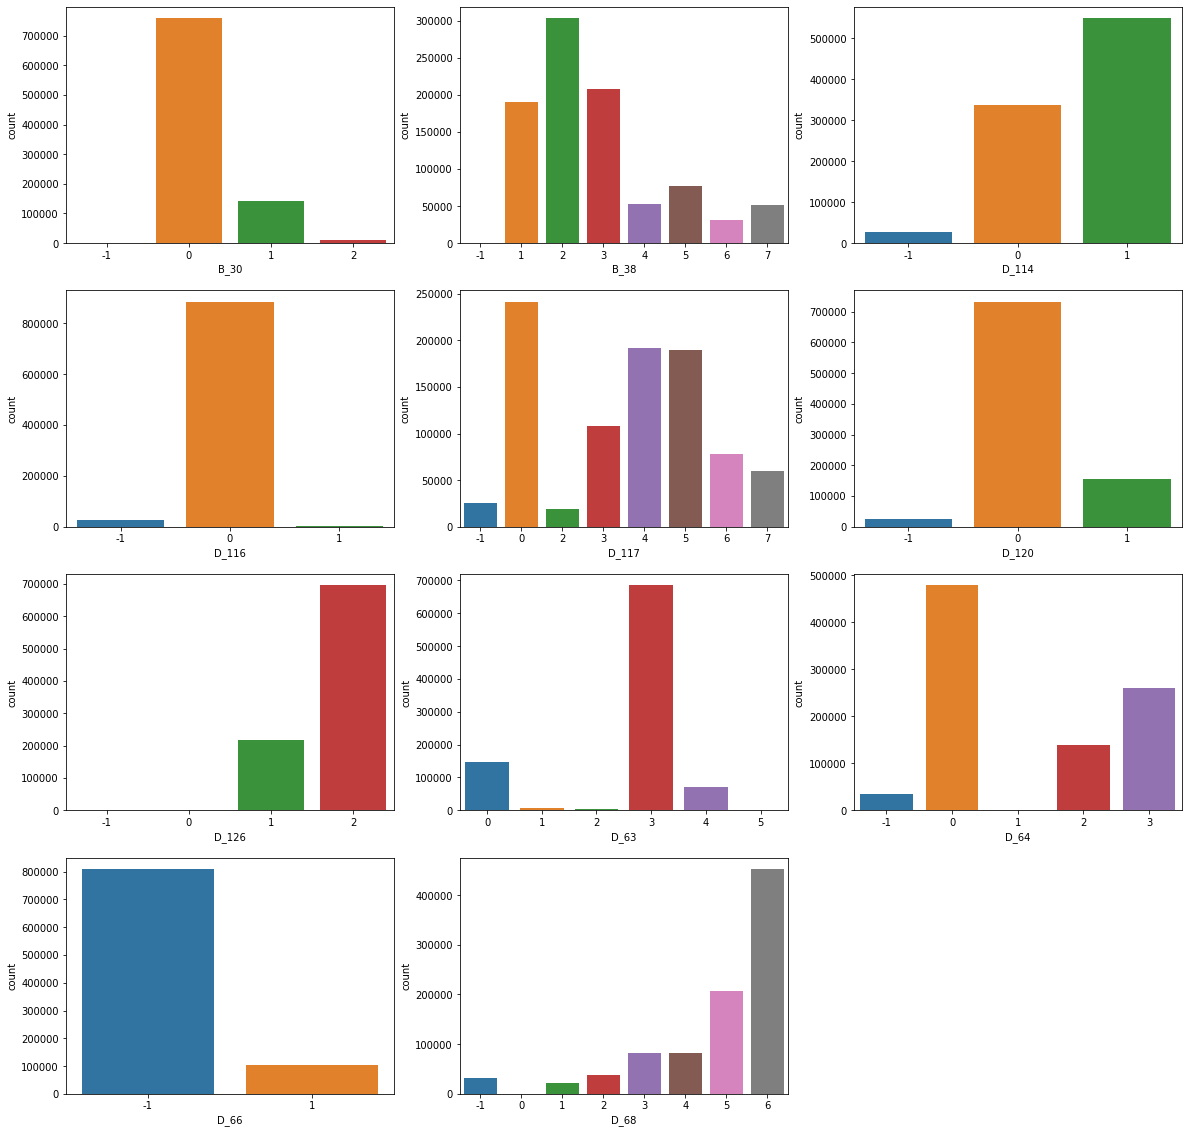

In [30]:
plt.figure(figsize=(20,20))

for i,feature in enumerate(cat):
    plt.subplot(4,3,i+1)
    sns.countplot(train_df[feature])

In [31]:
train_df["target"].unique()

array([0, 1])

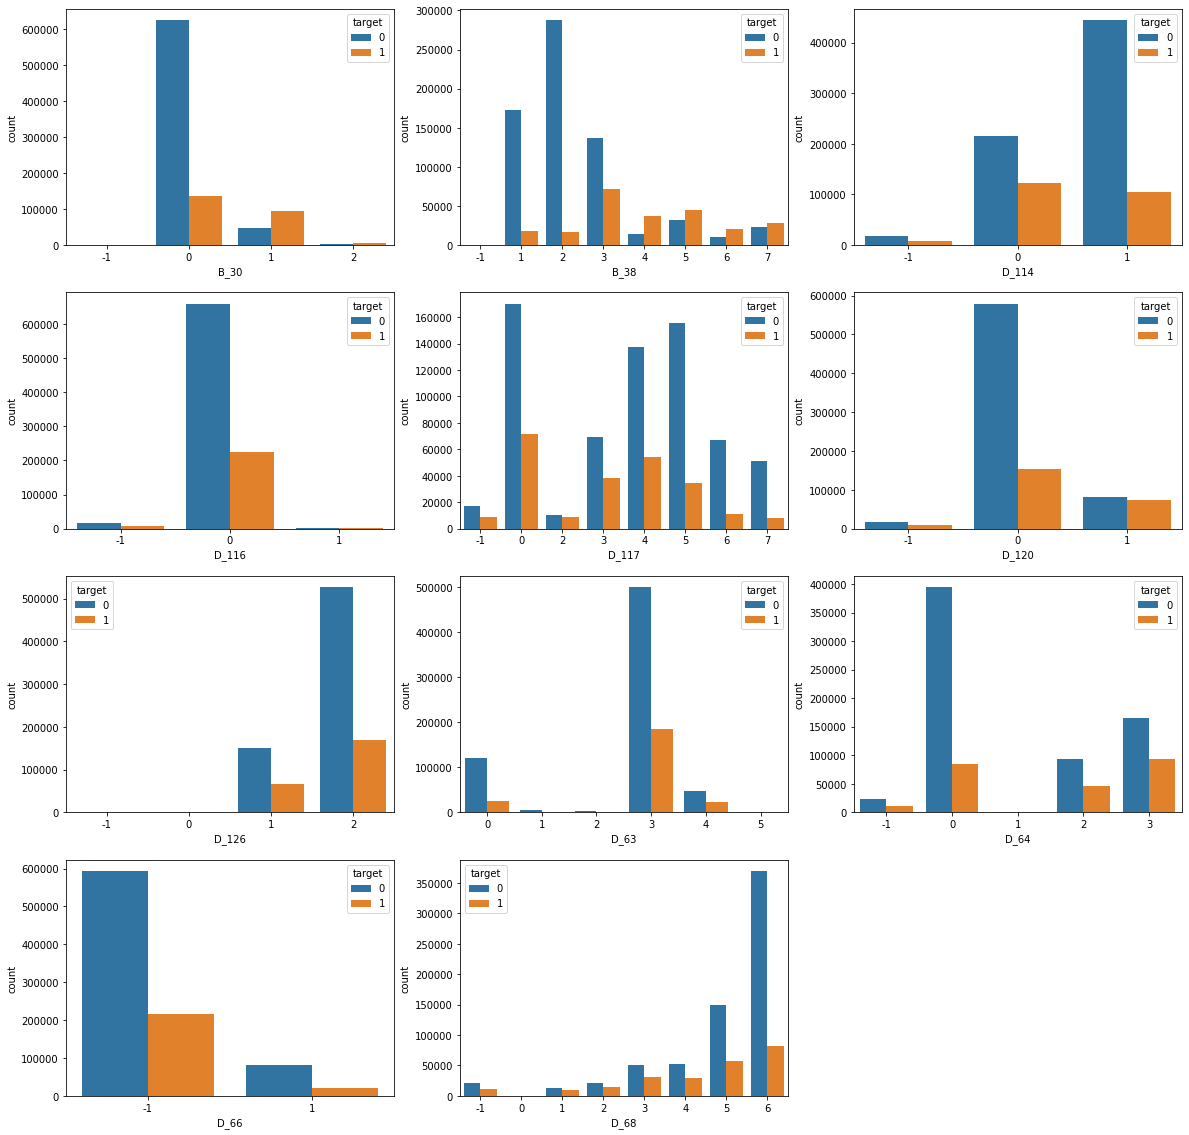

In [32]:
plt.figure(figsize=(20,20))

for i,feature in enumerate(cat):
    plt.subplot(4,3,i+1)
    sns.countplot(train_df[feature],hue=train_df['target'])

<AxesSubplot:xlabel='target', ylabel='count'>

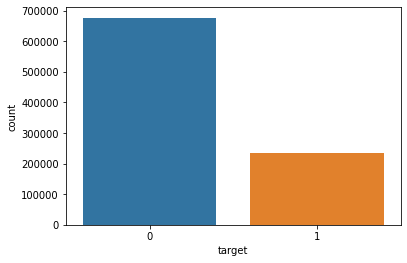

In [33]:
sns.countplot(train_df['target'])

Correlation between features

In [34]:
# For numeric columns filling null values
filtered_numerical_columns = train_df.select_dtypes(np.number).columns
train_df[filtered_numerical_columns] = train_df[filtered_numerical_columns].fillna(train_df[filtered_numerical_columns].mean())

In [35]:
train_df.isnull().sum()

customer_ID    0
S_2            0
P_2            0
D_39           0
B_1            0
              ..
D_141          0
D_143          0
D_144          0
D_145          0
target         0
Length: 179, dtype: int64

In [36]:
for i in filtered_numerical_columns:
    print(i + " Attribute is  of Data Type : "+ str(train_df[i].dtypes))

P_2 Attribute is  of Data Type : float32
D_39 Attribute is  of Data Type : int16
B_1 Attribute is  of Data Type : float32
B_2 Attribute is  of Data Type : float32
R_1 Attribute is  of Data Type : float32
S_3 Attribute is  of Data Type : float32
D_41 Attribute is  of Data Type : float32
B_3 Attribute is  of Data Type : float32
D_43 Attribute is  of Data Type : float32
D_44 Attribute is  of Data Type : int8
B_4 Attribute is  of Data Type : int16
D_45 Attribute is  of Data Type : float32
B_5 Attribute is  of Data Type : float32
R_2 Attribute is  of Data Type : int8
D_46 Attribute is  of Data Type : float32
D_47 Attribute is  of Data Type : float32
D_48 Attribute is  of Data Type : float32
D_49 Attribute is  of Data Type : int16
B_6 Attribute is  of Data Type : float32
B_7 Attribute is  of Data Type : float32
B_8 Attribute is  of Data Type : float32
D_50 Attribute is  of Data Type : float32
D_51 Attribute is  of Data Type : int8
B_9 Attribute is  of Data Type : float32
R_3 Attribute is  of

In [37]:
train_df[filtered_numerical_columns][:5]

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_65,B_16,B_17,B_18,B_19,B_20,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,P_4,D_74,D_75,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,S_18,D_86,D_87,R_17,R_18,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,D_108,D_109,D_111,D_112,B_40,S_27,D_113,D_115,D_118,D_119,D_121,D_122,D_123,D_124,D_125,D_127,D_128,D_129,B_41,D_130,D_131,D_133,R_28,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145,target
0,0.937349,0,0.019837,1.008307,0.000607,0.102985,0.0,0.007454,0.162704,0,6,0.740062,0.132626,0,0.425848,0.538275,0.237232,-1,0.150155,0.060502,0.0,0.149338,2,0.001064,0,0.207560,0.647352,0.325464,0.050146,0.007260,0,1.0,0,0.077352,0.111060,2380,0.196520,0.166448,0.092181,0,0.005720,0.013617,0.029953,8,0.141639,0.228128,0.042265,19,0.453934,0,0,0.727049,1.0,0,0,0.187413,0.004807,872,0.003347,0.007434,0,0,0.312937,0,5,0.044315,0.0,0,0,0.008714,0.0,0.417256,0.009573,0.000013,0,0,0,-1,0.005027,1,0,0,0.002737,0,1,0.007090,1.0,0.098844,0,0,0.0,0,0,0,0,0,-1,0,0,1,0.000869,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0.933347,0.136322,0.950119,0.979136,0.003096,0.922532,1,1.015417,1.067105,-1,2,0.009383,0.018704,-1,1.003859,-1,0,-1,1.0,0.100918,0.979416,0,0.256733,0.253851,0.247433,0.719052,3,0,16,0,1,0.999822,1,0,0.0,0.0,0.000122,0,-1,-1,-1,-1,0,0,0.0,0,0.006346,0,0
1,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,0.162704,0,5,0.740102,0.231717,0,0.420521,0.539715,0.192376,-1,0.149564,0.058425,0.0,0.153461,2,0.009535,0,0.203524,0.629392,0.326101,0.034643,0.010260,0,1.0,0,0.105671,0.112294,1544,0.187285,0.166636,0.100107,0,0.007174,0.007397,0.010239,8,0.258461,0.227637,0.014553,15,0.446568,0,0,0.727049,1.0,0,0,0.184036,0.003945,702,0.005375,0.005469,0,0,0.377991,0,6,0.040367,0.0,0,0,0.002230,0.0,0.421334,0.006475,0.001068,0,0,0,-1,0.000026,1,0,0,0.007236,0,1,0.006550,1.0,0.084745,0,0,0.0,0,0,0,0,0,-1,0,0,1,0.003511,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0.917811,0.131801,0.936067,0.971994,0.001281,0.943340,1,1.014510,1.073985,-1,2,0.007441,0.008676,-1,1.006130,-1,0,-1,1.0,0.100454,0.928955,0,0.255787,0.260255,0.256656,0.719791,3,0,16,0,1,0.999737,1,0,0.0,0.0,0.006210,0,-1,-1,-1,-1,0,0,0.0,0,0.002970,0,0
2,0.878856,18,0.034558,1.005419,0.007248,0.159486,0.0,0.008733,0.062028,0,1,0.263736,0.010155,0,0.470223,0.398607,0.010117,-1,0.211673,0.033179,0.0,0.176479,1,0.011734,1,0.239160,0.517843,0.301616,0.006361,0.015018,0,1.0,0,0.136180,0.022597,996,0.047516,0.695723,0.008499,0,0.008624,0.054500,0.023292,16,0.524772,0.103022,0.003985,16,0.238523,0,0,0.727049,1.0,0,0,0.188421,0.002118,290,0.008382,0.005944,0,0,0.010515,0,7,0.014946,0.0,0,0,0.009167,0.0,0.224252,0.033150,0.007601,0,0,0,-1,0.000067,0,0,0,0.000015,0,-1,0.003619,1.0,0.014986,0,0,0.0,0,0,0,0,0,-1,0,0,1,0.009282,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.994174,0.140244,1.011297,0.975712,0.002006,0.001432,0,0.000000,0.376424,-1,0,0.004645,0.030284,-1,1.009403,-1,0,-1,1.0,0.019818,0.003480,0,0.448894,0.438787,0.444072,0.539496,2,0,4,0,0,1.006768,0,0,0.0,0.0,0.009592,0,-1,-1,-1,-1,0,0,0.0,0,0.002528,0,0
3,0.880519,6,0.034684,1.004028,0.006911,0.165509,0.0,0.005068,0.060646,0,1,0.266275,0.027000,0,0.438828,0.402195,0.014696,-1,0.167634,0.028411,0.0,0.176479,1,0.012926,1,0.242366,0.570898,0.297130,0.043929,0.014570,0,1.0,0,0.208516,0.019050,1284,0.036112,0.748383,0.017684,0,0.009756,0.127805,0.018667,15,0.411989,0.048978,0.009538,14,0.233980,0,0,0.727049,1.0,0,0,0.192371,0.007744,290,0.006190,0.007636,0,0,0.007636,0,6,0.014705,0.0,0,0,0.002383,0.0,0.227755,0.021153,0.000182,0,0,0,-1,0.006931,0,0,0,0.005375,0,-1,0.005414,1.0,0.019672,0,0,0.0,0,0,0,0,0,-1,0,0,1,0.005091,0,0,0,0

### Performing the Feature Encoding
Machine learning models can only work with numerical values. For this reason, it is necessary to transform the categorical values of the relevant features into numerical ones. This process is called feature encoding.

In [38]:
for col in cat:
    print('{} has {} categories'.format(col,train_df[col].nunique()))

B_30 has 4 categories
B_38 has 8 categories
D_114 has 3 categories
D_116 has 3 categories
D_117 has 8 categories
D_120 has 3 categories
D_126 has 4 categories
D_63 has 6 categories
D_64 has 5 categories
D_66 has 2 categories
D_68 has 8 categories


In [39]:
train_df['S_2'] = pd.to_datetime(train_df['S_2'], errors='coerce')

In [40]:
# Handling date column

train_df["S_2_day"] =train_df["S_2"].dt.day
train_df["S_2_month"] = train_df["S_2"].dt.month
train_df["S_2_year"] = train_df["S_2"].dt.year

In [41]:
# drop S_2
train_df.drop(columns=["S_2"], axis=1, inplace=True)

In [42]:
train_df['customer_ID'].head()

0    0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...
1    0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...
2    00000fd6641609c6ece5454664794f0340ad84dddce9a2...
3    00000fd6641609c6ece5454664794f0340ad84dddce9a2...
4    00001b22f846c82c51f6e3958ccd81970162bae8b007e8...
Name: customer_ID, dtype: object

In [43]:
# handling Cusotmer ID as it has unique data
train_df =train_df.groupby(['customer_ID']).nth(-1).reset_index(drop=True)

In [44]:
train_df.head()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,P_4,D_74,D_75,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_30,S_18,D_86,D_87,R_17,R_18,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_111,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,D_130,D_131,D_133,R_28,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145,target,S_2_day,S_2_month,S_2_year
0,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,0.162704,0,5,0.740102,0.231717,0,0.420521,0.539715,0.192376,-1,0.149564,0.058425,0.000000,0.153461,2,0.009535,0,0.203524,0.629392,0.326101,0.034643,0.010260,0,1.0,0,0.105671,0.112294,1544,0.187285,0.166636,0.100107,0,0.007174,0.007397,0.010239,8,0.258461,0.227637,0.014553,15,0.446568,0,0,0,0,0.727049,1.000000,0,-1,0,6,0.184036,0.003945,702,0.005375,0.005469,0,0,0.377991,0,6,0.040367,0.0,0,0,0.002230,0.0,0.421334,0.006475,0.001068,0,0,0,-1,0.000026,1,0,0,0.007236,0,1,0.006550,1.0,0.084745,0,0,0.0,0,0,0,0,0,0,-1,0,0,1,0.003511,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0.917811,0.131801,0.936067,0.971994,0.001281,0.943340,1,1.014510,1.073985,-1,2,0.007441,0.008676,-1,1.006130,2,-1,0,-1,1.0,0.100454,0.928955,0,1,0.255787,0,5,0.260255,0.256656,0,0.719791,3,0,16,0,2,1,0.999737,1,0,0.000000,0.0,0.006210,0,-1,-1,-1,-1,0,0,0.0,0,0.002970,0,0,13,3,2018
1,0.880519,6,0.034684,1.004028,0.006911,0.165509,0.0,0.005068,0.060646,0,1,0.266275,0.027000,0,0.438828,0.402195,0.014696,-1,0.167634,0.028411,0.000000,0.176479,1,0.012926,1,0.242366,0.570898,0.297130,0.043929,0.014570,0,1.0,0,0.208516,0.019050,1284,0.036112,0.748383,0.017684,0,0.009756,0.127805,0.018667,15,0.411989,0.048978,0.009538,14,0.233980,3,0,0,0,0.727049,1.000000,0,-1,0,6,0.192371,0.007744,290,0.006190,0.007636,0,0,0.007636,0,6,0.014705,0.0,0,0,0.002383,0.0,0.227755,0.021153,0.000182,0,0,0,-1,0.006931,0,0,0,0.005375,0,-1,0.005414,1.0,0.019672,0,0,0.0,0,0,0,0,0,0,-1,0,0,1,0.005091,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.920889,0.132865,0.930629,0.977674,0.003213,0.001621,0,0.000000,0.376424,-1,0,0.007457,0.032899,-1,1.007599,2,-1,0,-1,1.0,0.019811,0.292214,0,1,0.454329,0,0,0.446036,0.436884,0,0.551341,2,0,4,0,2,0,0.999252,0,0,0.000000,0.0,0.002996,0,-1,-1,-1,-1,0,0,0.0,0,0.003169,0,0,25,3,2018
2,0.880875,0,0.004284,0.812649,0.006450,0.229894,0.0,0.007196,0.162704,0,2,0.251598,0.001557,0,0.433713,0.339125,0.080370,-1,0.183628,0.026981,0.000000,0.176479,1,0.009392,0,0.202159,0.628938,0.296313,0.001824,0.005092,1,1.0,0,0.223642,0.007158,0,0.098963,0.209386,0.001749,0,0.002847,0.054500,0.006699,15,0.002820,0.137834,0.006031,12,0.438647,3,2,0,0,0.727049,1.000000,0,-1,0,6,0.190958,0.008575,0,0.000036,0.009486,0,0,0.015025,0,8,0.020228,0.0,0,0,0.000552,0.0,0.407122,0.007427,0.009752,0,0,0,-1,0.009305,0,0,0,0.005475,0,-1,0.000159,1.0,0.030023,0,0,0.0,0,0,0,0,0,0,-1,0,0,1,0.006258,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.302868,0.132692,0.086479,0.972368,0.004705,0.009786,0,0.000000,0.376424,-1,0,0.005196,0.004723,-1,1.003010,1,-1,0,-1,1.0,0.024902,0.312540,0,1,0.388621,0,0,0.368051,0.369018,0,0.444615,1,0,7,0,2,0,0.000000,0,0,0.000000,0.0,0.009881,0,-1,-1,-1,-1,0,0,0.0,0,0.000834,0,0,12,3,2018
3,0.621776,0,0.012564,1.006183,0.007829,0.287766,0.0,0.009937,0.046104,0,0,0.085103,0.118818,0,0.410723,0.414224,0.407567,-1,0.174331,0.011969,1.005561,0.430318,1,0.020526,2,0.198356,0.672080,0.411625,0.022970,0.005491,0,1.0,0,0.279464,0.074835,528,0.021400,0.554483,0.055897,0,0.009294,0.011429,0.017101,29,0.394758,0.026844,0.002199,14,0.434503,3,0,0,1

### Label Encoding ---> Because there are less no. of categories in each column
LabelEncoder can be used to normalize labels. It can also be used to transform non-numerical labels (as long as they are hashable and comparable) to numerical labels. Fit label encoder.


In [45]:
 from sklearn.preprocessing import LabelEncoder

In [46]:
le=LabelEncoder()

In [47]:
for col in cat:
    train_df[col]=le.fit_transform(train_df[col])

In [48]:
train_df.head()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,P_4,D_74,D_75,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_30,S_18,D_86,D_87,R_17,R_18,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_111,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,D_130,D_131,D_133,R_28,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145,target,S_2_day,S_2_month,S_2_year
0,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,0.162704,0,5,0.740102,0.231717,0,0.420521,0.539715,0.192376,-1,0.149564,0.058425,0.000000,0.153461,2,0.009535,0,0.203524,0.629392,0.326101,0.034643,0.010260,0,1.0,0,0.105671,0.112294,1544,0.187285,0.166636,0.100107,0,0.007174,0.007397,0.010239,8,0.258461,0.227637,0.014553,15,0.446568,0,1,0,0,0.727049,1.000000,0,0,0,6,0.184036,0.003945,702,0.005375,0.005469,0,0,0.377991,0,6,0.040367,0.0,0,0,0.002230,0.0,0.421334,0.006475,0.001068,0,0,0,-1,0.000026,1,0,0,0.007236,0,1,0.006550,1.0,0.084745,0,0,0.0,0,0,0,1,0,0,-1,0,0,1,0.003511,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0.917811,0.131801,0.936067,0.971994,0.001281,0.943340,1,1.014510,1.073985,-1,2,0.007441,0.008676,-1,1.006130,2,-1,0,-1,1.0,0.100454,0.928955,0,2,0.255787,1,5,0.260255,0.256656,1,0.719791,3,0,16,0,1,1,0.999737,1,0,0.000000,0.0,0.006210,0,-1,-1,-1,-1,0,0,0.0,0,0.002970,0,0,13,3,2018
1,0.880519,6,0.034684,1.004028,0.006911,0.165509,0.0,0.005068,0.060646,0,1,0.266275,0.027000,0,0.438828,0.402195,0.014696,-1,0.167634,0.028411,0.000000,0.176479,1,0.012926,1,0.242366,0.570898,0.297130,0.043929,0.014570,0,1.0,0,0.208516,0.019050,1284,0.036112,0.748383,0.017684,0,0.009756,0.127805,0.018667,15,0.411989,0.048978,0.009538,14,0.233980,3,1,0,0,0.727049,1.000000,0,0,0,6,0.192371,0.007744,290,0.006190,0.007636,0,0,0.007636,0,6,0.014705,0.0,0,0,0.002383,0.0,0.227755,0.021153,0.000182,0,0,0,-1,0.006931,0,0,0,0.005375,0,-1,0.005414,1.0,0.019672,0,0,0.0,0,0,0,1,0,0,-1,0,0,1,0.005091,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.920889,0.132865,0.930629,0.977674,0.003213,0.001621,0,0.000000,0.376424,-1,0,0.007457,0.032899,-1,1.007599,2,-1,0,-1,1.0,0.019811,0.292214,0,2,0.454329,1,1,0.446036,0.436884,1,0.551341,2,0,4,0,1,0,0.999252,0,0,0.000000,0.0,0.002996,0,-1,-1,-1,-1,0,0,0.0,0,0.003169,0,0,25,3,2018
2,0.880875,0,0.004284,0.812649,0.006450,0.229894,0.0,0.007196,0.162704,0,2,0.251598,0.001557,0,0.433713,0.339125,0.080370,-1,0.183628,0.026981,0.000000,0.176479,1,0.009392,0,0.202159,0.628938,0.296313,0.001824,0.005092,1,1.0,0,0.223642,0.007158,0,0.098963,0.209386,0.001749,0,0.002847,0.054500,0.006699,15,0.002820,0.137834,0.006031,12,0.438647,3,2,0,0,0.727049,1.000000,0,0,0,6,0.190958,0.008575,0,0.000036,0.009486,0,0,0.015025,0,8,0.020228,0.0,0,0,0.000552,0.0,0.407122,0.007427,0.009752,0,0,0,-1,0.009305,0,0,0,0.005475,0,-1,0.000159,1.0,0.030023,0,0,0.0,0,0,0,1,0,0,-1,0,0,1,0.006258,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.302868,0.132692,0.086479,0.972368,0.004705,0.009786,0,0.000000,0.376424,-1,0,0.005196,0.004723,-1,1.003010,1,-1,0,-1,1.0,0.024902,0.312540,0,2,0.388621,1,1,0.368051,0.369018,1,0.444615,1,0,7,0,1,0,0.000000,0,0,0.000000,0.0,0.009881,0,-1,-1,-1,-1,0,0,0.0,0,0.000834,0,0,12,3,2018
3,0.621776,0,0.012564,1.006183,0.007829,0.287766,0.0,0.009937,0.046104,0,0,0.085103,0.118818,0,0.410723,0.414224,0.407567,-1,0.174331,0.011969,1.005561,0.430318,1,0.020526,2,0.198356,0.672080,0.411625,0.022970,0.005491,0,1.0,0,0.279464,0.074835,528,0.021400,0.554483,0.055897,0,0.009294,0.011429,0.017101,29,0.394758,0.026844,0.002199,14,0.434503,3,1,0,1,1.

### Selecting important features
SelectKBest: Feature selection is a technique where we choose those features in our data that contribute most to the target variable. In other words we choose the best predictors for the target variable. The classes in the sklearn.

chi2: A chi-square (χ2) statistic is a test that measures how a model compares to actual observed data. ... The chi-square statistic compares the size any discrepancies between the expected results and the actual results, given the size of the sample and the number of variables in the relationship.

In [49]:
from sklearn.feature_selection import SelectKBest

In [50]:
from sklearn.feature_selection import chi2,f_regression,mutual_info_classif

In [51]:
ind_col=[col for col in train_df.columns if col!='target']
dep_col='target'

### As customer ID is not a usefull metric we will not use it for our model building

In [52]:
X=train_df[ind_col]
y=train_df[dep_col]

In [53]:
X.head()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,P_4,D_74,D_75,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_30,S_18,D_86,D_87,R_17,R_18,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_111,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,D_130,D_131,D_133,R_28,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145,S_2_day,S_2_month,S_2_year
0,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,0.162704,0,5,0.740102,0.231717,0,0.420521,0.539715,0.192376,-1,0.149564,0.058425,0.000000,0.153461,2,0.009535,0,0.203524,0.629392,0.326101,0.034643,0.010260,0,1.0,0,0.105671,0.112294,1544,0.187285,0.166636,0.100107,0,0.007174,0.007397,0.010239,8,0.258461,0.227637,0.014553,15,0.446568,0,1,0,0,0.727049,1.000000,0,0,0,6,0.184036,0.003945,702,0.005375,0.005469,0,0,0.377991,0,6,0.040367,0.0,0,0,0.002230,0.0,0.421334,0.006475,0.001068,0,0,0,-1,0.000026,1,0,0,0.007236,0,1,0.006550,1.0,0.084745,0,0,0.0,0,0,0,1,0,0,-1,0,0,1,0.003511,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0.917811,0.131801,0.936067,0.971994,0.001281,0.943340,1,1.014510,1.073985,-1,2,0.007441,0.008676,-1,1.006130,2,-1,0,-1,1.0,0.100454,0.928955,0,2,0.255787,1,5,0.260255,0.256656,1,0.719791,3,0,16,0,1,1,0.999737,1,0,0.000000,0.0,0.006210,0,-1,-1,-1,-1,0,0,0.0,0,0.002970,0,13,3,2018
1,0.880519,6,0.034684,1.004028,0.006911,0.165509,0.0,0.005068,0.060646,0,1,0.266275,0.027000,0,0.438828,0.402195,0.014696,-1,0.167634,0.028411,0.000000,0.176479,1,0.012926,1,0.242366,0.570898,0.297130,0.043929,0.014570,0,1.0,0,0.208516,0.019050,1284,0.036112,0.748383,0.017684,0,0.009756,0.127805,0.018667,15,0.411989,0.048978,0.009538,14,0.233980,3,1,0,0,0.727049,1.000000,0,0,0,6,0.192371,0.007744,290,0.006190,0.007636,0,0,0.007636,0,6,0.014705,0.0,0,0,0.002383,0.0,0.227755,0.021153,0.000182,0,0,0,-1,0.006931,0,0,0,0.005375,0,-1,0.005414,1.0,0.019672,0,0,0.0,0,0,0,1,0,0,-1,0,0,1,0.005091,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.920889,0.132865,0.930629,0.977674,0.003213,0.001621,0,0.000000,0.376424,-1,0,0.007457,0.032899,-1,1.007599,2,-1,0,-1,1.0,0.019811,0.292214,0,2,0.454329,1,1,0.446036,0.436884,1,0.551341,2,0,4,0,1,0,0.999252,0,0,0.000000,0.0,0.002996,0,-1,-1,-1,-1,0,0,0.0,0,0.003169,0,25,3,2018
2,0.880875,0,0.004284,0.812649,0.006450,0.229894,0.0,0.007196,0.162704,0,2,0.251598,0.001557,0,0.433713,0.339125,0.080370,-1,0.183628,0.026981,0.000000,0.176479,1,0.009392,0,0.202159,0.628938,0.296313,0.001824,0.005092,1,1.0,0,0.223642,0.007158,0,0.098963,0.209386,0.001749,0,0.002847,0.054500,0.006699,15,0.002820,0.137834,0.006031,12,0.438647,3,2,0,0,0.727049,1.000000,0,0,0,6,0.190958,0.008575,0,0.000036,0.009486,0,0,0.015025,0,8,0.020228,0.0,0,0,0.000552,0.0,0.407122,0.007427,0.009752,0,0,0,-1,0.009305,0,0,0,0.005475,0,-1,0.000159,1.0,0.030023,0,0,0.0,0,0,0,1,0,0,-1,0,0,1,0.006258,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.302868,0.132692,0.086479,0.972368,0.004705,0.009786,0,0.000000,0.376424,-1,0,0.005196,0.004723,-1,1.003010,1,-1,0,-1,1.0,0.024902,0.312540,0,2,0.388621,1,1,0.368051,0.369018,1,0.444615,1,0,7,0,1,0,0.000000,0,0,0.000000,0.0,0.009881,0,-1,-1,-1,-1,0,0,0.0,0,0.000834,0,12,3,2018
3,0.621776,0,0.012564,1.006183,0.007829,0.287766,0.0,0.009937,0.046104,0,0,0.085103,0.118818,0,0.410723,0.414224,0.407567,-1,0.174331,0.011969,1.005561,0.430318,1,0.020526,2,0.198356,0.672080,0.411625,0.022970,0.005491,0,1.0,0,0.279464,0.074835,528,0.021400,0.554483,0.055897,0,0.009294,0.011429,0.017101,29,0.394758,0.026844,0.002199,14,0.434503,3,1,0,1,1.007434,1.0000

In [54]:
X.shape

(458913, 179)

In [55]:
imp_features=SelectKBest(score_func=mutual_info_classif,k=100)

In [56]:
imp_features=imp_features.fit(X,y)

In [57]:
imp_features

SelectKBest(k=100, score_func=<function mutual_info_classif at 0x7f6e1097b170>)

In [58]:
imp_features.scores_

array([2.58321123e-01, 8.07143238e-02, 1.61812141e-01, 1.67823751e-01,
       1.12618336e-01, 8.85073365e-02, 8.06216911e-02, 1.62608373e-01,
       5.30643393e-02, 1.77247578e-01, 1.36102732e-01, 5.70927603e-02,
       3.47039610e-02, 7.61930583e-02, 3.82350918e-02, 4.95465297e-02,
       1.93866847e-01, 5.29613450e-02, 1.55743436e-01, 1.65381119e-01,
       4.84541458e-02, 2.97369311e-02, 6.00339053e-02, 1.80152846e-01,
       4.36739750e-02, 7.74210038e-02, 7.26775308e-02, 1.53492493e-01,
       2.13106663e-02, 1.54368732e-01, 1.42988895e-02, 1.03243846e-01,
       5.28231997e-02, 8.25413919e-02, 2.70763134e-02, 4.37190922e-02,
       1.49065581e-01, 3.45138230e-02, 2.25650371e-02, 5.65930394e-02,
       1.31621478e-01, 2.47552130e-03, 7.72453590e-02, 3.45787399e-02,
       6.21512811e-02, 1.69123187e-01, 2.15763052e-03, 1.29444922e-02,
       1.38567907e-01, 4.48848919e-02, 4.34370924e-02, 5.28731585e-02,
       1.21907869e-01, 1.33110645e-01, 1.88812444e-01, 1.17581773e-01,
      

In [59]:
datascore=pd.DataFrame(imp_features.scores_,columns=['Score'])

In [60]:
datascore

,Score
0,0.258321
1,0.080714
2,0.161812
3,0.167824
4,0.112618
...,...
174,0.000062
175,0.009111
176,0.002588
177,0.062092


In [61]:
X.columns

Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_43',
       'D_44',
       ...
       'D_138', 'D_139', 'D_140', 'D_141', 'D_143', 'D_144', 'D_145',
       'S_2_day', 'S_2_month', 'S_2_year'],
      dtype='object', length=179)

In [62]:
dfcols=pd.DataFrame(X.columns)

In [63]:
dfcols


,0
0,P_2
1,D_39
2,B_1
3,B_2
4,R_1
...,...
174,D_144
175,D_145
176,S_2_day
177,S_2_month


In [64]:
features_rank=pd.concat([dfcols,datascore],axis=1)
features_rank

,0,Score
0,P_2,0.258321
1,D_39,0.080714
2,B_1,0.161812
3,B_2,0.167824
4,R_1,0.112618
...,...,...
174,D_144,0.000062
175,D_145,0.009111
176,S_2_day,0.002588
177,S_2_month,0.062092


In [65]:
features_rank.columns=['features','score']

In [66]:
features_rank

,features,score
0,P_2,0.258321
1,D_39,0.080714
2,B_1,0.161812
3,B_2,0.167824
4,R_1,0.112618
...,...,...
174,D_144,0.000062
175,D_145,0.009111
176,S_2_day,0.002588
177,S_2_month,0.062092


In [67]:
features_rank.nlargest(100,'score')

,features,score
0,P_2,0.258321
16,D_48,0.193867
54,B_18,0.188812
23,B_9,0.180153
9,D_44,0.177248
...,...,...
143,S_27,0.036541
12,B_5,0.034704
43,D_59,0.034579
37,D_56,0.034514


In [68]:
selected=features_rank.nlargest(100,'score')['features'].values

In [69]:
selected

array(['P_2', 'D_48', 'B_18', 'B_9', 'D_44', 'B_33', 'D_61', 'B_2',
       'D_75', 'B_7', 'B_23', 'B_3', 'B_1', 'B_37', 'B_38', 'B_6', 'B_11',
       'B_10', 'D_55', 'B_20', 'D_62', 'B_4', 'D_74', 'B_17', 'D_58',
       'B_40', 'B_30', 'B_16', 'B_19', 'D_112', 'R_1', 'D_54', 'D_77',
       'S_25', 'S_23', 'R_26', 'S_3', 'B_22', 'S_7', 'B_25', 'D_39',
       'D_41', 'R_12', 'R_9', 'D_136', 'D_52', 'B_14', 'S_22', 'D_138',
       'R_2', 'D_137', 'D_135', 'B_28', 'B_31', 'P_3', 'D_78', 'D_87',
       'D_120', 'D_111', 'D_116', 'D_108', 'D_106', 'S_24', 'D_60',
       'S_2_month', 'R_6', 'D_51', 'D_114', 'D_84', 'D_45', 'D_70', 'R_5',
       'R_7', 'B_26', 'D_43', 'D_49', 'D_65', 'R_4', 'R_27', 'D_47',
       'B_8', 'S_15', 'S_2_year', 'R_10', 'D_126', 'D_63', 'D_68', 'S_8',
       'R_3', 'D_82', 'D_64', 'R_8', 'D_81', 'D_46', 'D_72', 'S_27',
       'B_5', 'D_59', 'D_56', 'D_71'], dtype=object)

In [70]:
X_new=X[selected]

In [71]:
cols = X_new.columns.tolist()

In [72]:
X_new[cols]

,P_2,D_48,B_18,B_9,D_44,B_33,D_61,B_2,D_75,B_7,B_23,B_3,B_1,B_37,B_38,B_6,B_11,B_10,D_55,B_20,D_62,B_4,D_74,B_17,D_58,B_40,B_30,B_16,B_19,D_112,R_1,D_54,D_77,S_25,S_23,R_26,S_3,B_22,S_7,B_25,D_39,D_41,R_12,R_9,D_136,D_52,B_14,S_22,D_138,R_2,D_137,D_135,B_28,B_31,P_3,D_78,D_87,D_120,D_111,D_116,D_108,D_106,S_24,D_60,S_2_month,R_6,D_51,D_114,D_84,D_45,D_70,R_5,R_7,B_26,D_43,D_49,D_65,R_4,R_27,D_47,B_8,S_15,S_2_year,R_10,D_126,D_63,D_68,S_8,R_3,D_82,D_64,R_8,D_81,D_46,D_72,S_27,B_5,D_59,D_56,D_71
0,0.934745,0.192376,1.000000,0.009535,0,1,0.227637,1.007647,0,0.058425,0.040367,0.007174,0.009382,0.008676,2,0.149564,0.010260,0.326101,0.187285,0,0.446568,5,0,0.727049,0.007174,0.100454,1,0,0,1.0,0.006104,1.0,0.421334,0.971994,0.131801,-1,0.135021,0,0.105671,0.006475,0,0.0,1.0,-1,-1,0.203524,0.010239,0.917811,-1,0,-1,-1,0.084745,1,0.629392,0,-1,1,-1,1,-1,-1,0.936067,0.258461,3,0.003945,2,2,0,0.740102,0,0,0.0,0.001068,0.162704,-1,0,0,1.006130,0.539715,0.000000,6,2018,0,1,0,6,1544,0,1,1,0,0,0.420521,0,0.928955,0.231717,8,0.166636,0.377991
1,0.880519,0.014696,1.000000,0.012926,0,1,0.048978,1.004028,0,0.028411,0.014705,0.005068,0.034684,0.032899,2,0.167634,0.014570,0.297130,0.036112,0,0.233980,1,0,0.727049,0.009756,0.019811,1,0,0,1.0,0.006911,1.0,0.227755,0.977674,0.132865,-1,0.165509,0,0.208516,0.021153,6,0.0,1.0,-1,-1,0.242366,0.018667,0.920889,-1,0,-1,-1,0.019672,1,0.570898,0,-1,1,-1,1,-1,-1,0.930629,0.411989,3,0.007744,1,2,0,0.266275,0,0,0.0,0.000182,0.060646,-1,0,0,1.007599,0.402195,0.000000,6,2018,0,1,3,6,1284,1,-1,1,0,0,0.438828,0,0.292214,0.027000,15,0.748383,0.007636
2,0.880875,0.080370,1.000000,0.009392,0,1,0.137834,0.812649,0,0.026981,0.020228,0.007196,0.004284,0.004723,1,0.183628,0.005092,0.296313,0.098963,0,0.438647,2,0,0.727049,0.002847,0.024902,1,0,0,1.0,0.006450,1.0,0.407122,0.972368,0.132692,-1,0.229894,0,0.223642,0.007427,0,0.0,1.0,-1,-1,0.202159,0.006699,0.302868,-1,0,-1,-1,0.030023,1,0.628938,0,-1,1,-1,1,-1,-1,0.086479,0.002820,3,0.008575,1,2,0,0.251598,0,0,0.0,0.009752,0.162704,-1,0,0,1.003010,0.339125,0.000000,8,2018,0,1,3,6,0,0,-1,2,0,0,0.433713,0,0.312540,0.001557,15,0.209386,0.015025
3,0.621776,0.407567,1.000000,0.020526,0,1,0.026844,1.006183,0,0.011969,0.005060,0.009937,0.012564,0.007375,2,0.174331,0.005491,0.411625,0.021400,0,0.434503,0,0,1.007434,0.009294,0.031024,1,1,0,1.0,0.007829,1.0,0.401139,0.974041,0.132833,-1,0.287766,0,0.279464,0.014266,0,0.0,1.0,-1,-1,0.198356,0.017101,0.931634,-1,0,-1,-1,0.010497,1,0.672080,0,-1,1,-1,1,-1,-1,0.957105,0.394758,3,0.000952,1,2,0,0.085103,0,0,0.0,0.004983,0.046104,-1,0,0,1.004479,0.414224,1.005561,8,2018,0,1,3,3,528,2,-1,1,0,0,0.410723,0,0.680603,0.118818,29,0.554483,0.010685
4,0.871900,0.325121,0.531486,0.004027,0,1,0.600739,0.815746,2,0.159818,0.145214,0.005528,0.007679,0.007787,1,0.048857,0.001001,0.125195,0.254067,0,0.422841,21,2,0.727049,0.382744,0.116816,1,0,0,1.0,0.001247,1.0,0.392566,0.971905,0.132099,-1,0.229894,0,0.223642,0.009528,0,0.0,1.0,-1,-1,0.253811,0.009469,0.297843,-1,0,-1,-1,0.250254,1,0.570419,0,-1,1,-1,1,-1,-1,0.081818,0.002670,3,0.003575,0,2,0,0.069952,0,0,0.0,0.005802,0.044671,-1,0,0,1.006920,0.480303,1.005185,8,2018,0,1,3,6,0,0,-1,1,0,0,0.465525,0,0.312540,0.004855,28,0.183075,0.016457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,0.844229,0.058638,1.000000,0.170243,0,1,0.074227,1.009866,0,0.029921,0.025304,0.005893,0.028515,0.027725,2,0.317123,0.024425,0.436133,0.035347,0,0.457274,4,0,0.727049,0.008702,0.008413,1,0,0,1.0,0.001928,1.0,0.423810,0.974446,0.136618,-1,0.128707,0,0.087793,0.270649,15,0.0,1.0,-1,-1,0.210908,0.154710,0.948851,-1,0,-1,-1,0.080837,1,0.531050,0,-1,2,-1,1,-1,-1,0.964128

In [73]:
print(X_new.shape,y.shape)

(458913, 100) (458913,)


In [74]:
X_new.head(20)

,P_2,D_48,B_18,B_9,D_44,B_33,D_61,B_2,D_75,B_7,B_23,B_3,B_1,B_37,B_38,B_6,B_11,B_10,D_55,B_20,D_62,B_4,D_74,B_17,D_58,B_40,B_30,B_16,B_19,D_112,R_1,D_54,D_77,S_25,S_23,R_26,S_3,B_22,S_7,B_25,D_39,D_41,R_12,R_9,D_136,D_52,B_14,S_22,D_138,R_2,D_137,D_135,B_28,B_31,P_3,D_78,D_87,D_120,D_111,D_116,D_108,D_106,S_24,D_60,S_2_month,R_6,D_51,D_114,D_84,D_45,D_70,R_5,R_7,B_26,D_43,D_49,D_65,R_4,R_27,D_47,B_8,S_15,S_2_year,R_10,D_126,D_63,D_68,S_8,R_3,D_82,D_64,R_8,D_81,D_46,D_72,S_27,B_5,D_59,D_56,D_71
0,0.934745,0.192376,1.000000,0.009535,0,1,0.227637,1.007647,0,0.058425,0.040367,0.007174,0.009382,0.008676,2,0.149564,0.010260,0.326101,0.187285,0,0.446568,5,0,0.727049,0.007174,0.100454,1,0,0,1.000000,0.006104,1.000000,0.421334,0.971994,0.131801,-1,0.135021,0,0.105671,0.006475,0,0.000000,1.0,-1,-1,0.203524,0.010239,0.917811,-1,0,-1,-1,0.084745,1,0.629392,0,-1,1,-1,1,-1,-1,0.936067,0.258461,3,0.003945,2,2,0,0.740102,0,0,0.000000,0.001068,0.162704,-1,0,0,1.006130,0.539715,0.000000,6,2018,0,1,0,6,1544,0,1,1,0,0,0.420521,0,0.928955,0.231717,8,0.166636,0.377991
1,0.880519,0.014696,1.000000,0.012926,0,1,0.048978,1.004028,0,0.028411,0.014705,0.005068,0.034684,0.032899,2,0.167634,0.014570,0.297130,0.036112,0,0.233980,1,0,0.727049,0.009756,0.019811,1,0,0,1.000000,0.006911,1.000000,0.227755,0.977674,0.132865,-1,0.165509,0,0.208516,0.021153,6,0.000000,1.0,-1,-1,0.242366,0.018667,0.920889,-1,0,-1,-1,0.019672,1,0.570898,0,-1,1,-1,1,-1,-1,0.930629,0.411989,3,0.007744,1,2,0,0.266275,0,0,0.000000,0.000182,0.060646,-1,0,0,1.007599,0.402195,0.000000,6,2018,0,1,3,6,1284,1,-1,1,0,0,0.438828,0,0.292214,0.027000,15,0.748383,0.007636
2,0.880875,0.080370,1.000000,0.009392,0,1,0.137834,0.812649,0,0.026981,0.020228,0.007196,0.004284,0.004723,1,0.183628,0.005092,0.296313,0.098963,0,0.438647,2,0,0.727049,0.002847,0.024902,1,0,0,1.000000,0.006450,1.000000,0.407122,0.972368,0.132692,-1,0.229894,0,0.223642,0.007427,0,0.000000,1.0,-1,-1,0.202159,0.006699,0.302868,-1,0,-1,-1,0.030023,1,0.628938,0,-1,1,-1,1,-1,-1,0.086479,0.002820,3,0.008575,1,2,0,0.251598,0,0,0.000000,0.009752,0.162704,-1,0,0,1.003010,0.339125,0.000000,8,2018,0,1,3,6,0,0,-1,2,0,0,0.433713,0,0.312540,0.001557,15,0.209386,0.015025
3,0.621776,0.407567,1.000000,0.020526,0,1,0.026844,1.006183,0,0.011969,0.005060,0.009937,0.012564,0.007375,2,0.174331,0.005491,0.411625,0.021400,0,0.434503,0,0,1.007434,0.009294,0.031024,1,1,0,1.000000,0.007829,1.000000,0.401139,0.974041,0.132833,-1,0.287766,0,0.279464,0.014266,0,0.000000,1.0,-1,-1,0.198356,0.017101,0.931634,-1,0,-1,-1,0.010497,1,0.672080,0,-1,1,-1,1,-1,-1,0.957105,0.394758,3,0.000952,1,2,0,0.085103,0,0,0.000000,0.004983,0.046104,-1,0,0,1.004479,0.414224,1.005561,8,2018,0,1,3,3,528,2,-1,1,0,0,0.410723,0,0.680603,0.118818,29,0.554483,0.010685
4,0.871900,0.325121,0.531486,0.004027,0,1,0.600739,0.815746,2,0.159818,0.145214,0.005528,0.007679,0.007787,1,0.048857,0.001001,0.125195,0.254067,0,0.422841,21,2,0.727049,0.382744,0.116816,1,0,0,1.000000,0.001247,1.000000,0.392566,0.971905,0.132099,-1,0.229894,0,0.223642,0.009528,0,0.000000,1.0,-1,-1,0.253811,0.009469,0.297843,-1,0,-1,-1,0.250254,1,0.570419,0,-1,1,-1,1,-1,-1,0.081818,0.002670,3,0.003575,0,2,0,0.069952,0,0,0.000000,0.005802,0.044671,-1,0,0,1.006920,0.480303,1.005185,8,2018,0,1,3,6,0,0,-1,1,0,0,0.465525,0,0.312540,0.004855,28,0.183075,0.016457
5,0.824061,0.407567,1.000000,0.006484,-1,1,0.450303,1.001713,0,0.006804,0.001999,0.006134,0.007853,0.003932,2,0.195964,0.004297,0.292997,0.329373,0,0.188604,0,0,0.727049,0.009575,0.008658,1,2,0,1.000000,0.006885,1.000000,0.259691,0.977194,0.138215,-1,0.395740,0,0.377045,0.002913,0,0.000000,1.0,-1,-1,0.033931,0.006910,0.300341,-1,0,-1,-1,0.005702,1,0.684352,-1,-1,1,-1,1,-1,-1,0.077994,1.001062,3,0.006363,0,2,0,0.341221,0,0,0.000000,0.006430,0.013881,-1,0,0,1.002521,1.053603,0.000000,8,2018,0,1,3,6,0,0,-1,2,0,0,0.480609,0,0.003215,0.012747,5,0.208687,0.012460
6,0.477116,0.676813,0.688722,0.014493,0,1,0.106100,1.009217,1,0.010545,0.008774,0.125927,0.009413,0.003996,3,0.0656

In [75]:
from sklearn.model_selection import train_test_split

In [76]:
X_train,X_test,y_train,y_test=train_test_split(X_new,y,random_state=0,test_size=0.3)

In [77]:
X_train.shape

(321239, 100)

In [78]:
y_train.value_counts() 

0    238083
1     83156
Name: target, dtype: int64

# XGBoost Classifier - For our Model
XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements Machine Learning algorithms under the Gradient Boosting framework. It provides a parallel tree boosting to solve many data science problems in a fast and accurate way.

# Since we are using XGBoost , feature scaling is not required

In [79]:
from xgboost import XGBClassifier

In [80]:
params={'learning-rate':[0,0.5,0.20,0.25],
        'max_depth':[5,8,10],
       'min_child_weight':[1,3,5,7],
       'gamma':[0.0,0.1,0.2,0.4],
       'colsample_bytree':[0.3,0.4,0.7]}

In [81]:
from sklearn.model_selection import RandomizedSearchCV

In [82]:
classifier=XGBClassifier()

In [83]:
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

In [84]:
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[15:41:15] WARNING: ../src/learner.cc:627: 
Parameters: { "learning-rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.

[15:41:15] WARNING: ../src/learner.cc:627: 
Parameters: { "learning-rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning-rate=0.2, max_depth=5, min_child_weight=3;, score=0.956 total time= 2.6min
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning-rate=0.2, max_depth=5, min_

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=

In [85]:
random_search.best_estimator_ 

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', learning-rate=0,
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

In [86]:
random_search.best_params_

{'min_child_weight': 1,
 'max_depth': 5,
 'learning-rate': 0,
 'gamma': 0.0,
 'colsample_bytree': 0.3}

In [87]:
classifier=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='', learning_rate=0.300000012, max_delta_step=0,
              max_depth=5, min_child_weight=1,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [88]:
classifier.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.2, gpu_id=-1, grow_policy='depthwise',
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=8, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [89]:
# https://www.kaggle.com/code/inversion/amex-competition-metric-python
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)


# Let's Predict our model Accuracy.

In [90]:
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import metrics

In [91]:
y_pred = classifier.predict(X_test)

In [92]:
y_pred_prob = classifier.predict_proba(X_test)[:,1]

In [93]:
y_test = pd.DataFrame(y_test, columns=["target"])
y_pred = pd.DataFrame(y_pred, columns=["prediction"])
y_pred_prob = pd.DataFrame(y_pred_prob, columns=["prediction"])

In [94]:
print('MAE:',metrics.mean_absolute_error(y_test,y_pred))
print('MSE:',metrics.mean_squared_error(y_test,y_pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

MAE: 0.10373055188343477
MSE: 0.10373055188343477
RMSE: 0.32207227742144273


In [95]:
confusion_matrix(y_test,y_pred)

array([[95081,  6921],
       [ 7360, 28312]])

In [96]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)

95081 6921 7360 28312


In [97]:
accuracy_score(y_test,y_pred)

0.8962694481165652

In [98]:
precision=tp/(tp+fp)
recall=tp/(tp+fn)
print("Precision : ",precision)
print("Recall : ",recall)
f1score=(2*precision*recall)/(precision+recall)
print("F1 score: ",f1score)

Precision :  0.8035648397808872
Recall :  0.793675712043059
F1 score:  0.7985896622241025


#  As the dataset is **imbalanced** accuracy can not be taken as a metric 
### F1 Score is our Model Metric # We Got Very Good F1 Score Using XGBoost : 79.9%<br>

# Official Metric 

In [99]:
# # computing metric score
amex_metric(y_test, y_pred_prob)

0.003666237094820028

# Test Results

In [ ]:
test_df = pd.read_parquet('../input/amex-data-integer-dtypes-parquet-format/test.parquet').groupby('customer_ID').tail(2).set_index('customer_ID', drop=True).sort_index()
test_df.head()

In [ ]:
test_df.shape

In [ ]:
final_test=test_df[selected]
final_test.head()

In [ ]:
final_test.shape

In [ ]:
final_test.head()

In [ ]:
sel_test=[col for col in final_test.columns if col!='customer_ID']
len(sel_test)

In [ ]:
df_final=final_test.copy()

In [ ]:
df_final.shape

In [ ]:
df_final=df_final.reset_index()

In [ ]:
df_final.head()

In [ ]:
df_final.drop_duplicates("customer_ID",inplace=True)

In [ ]:
df_final.shape

In [ ]:
test_data=df_final[sel_test]
test_data.shape

In [ ]:
df_final["prediction"]=xgb_classifier.predict(test_data)

In [ ]:
df_final.drop(selected,inplace=True,axis=1)
df_final.head()

In [ ]:
df_final=df_final.reset_index()

In [ ]:
df_final.drop("index",inplace=True,axis=1)

In [ ]:
df_final.head()

In [ ]:
df_final.shape

In [ ]:
df_final.head()

In [ ]:
df_final.index.nunique()

In [ ]:
df_final.shape

In [ ]:
df_final.to_csv("Submission_v4.csv",index=False)

# Saving The Model

In [99]:

import joblib
joblib.dump(classifier, "xgboost_classifier_v2.h5")

['xgboost_classifier_v2.h5']

In [101]:
# load the model
import joblib
xgb_classifier = joblib.load("./xgboost_classifier_v2.h5")

In [102]:
y_pred1=xgb_classifier.predict(X_test)
metrics.r2_score(y_test,y_pred1)

0.4596509363810345